### РАЗБИРАЕМ СУБТИТРЫ ###
Для выполнения задачи нам нужно создать датасет с данными обо всех субтитрах, что у нас есть. Для этого мы воспользуемся исходной таблицей с субтитрами, а также файлами, разложенными по соответствующим папкам.

In [44]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import seaborn as sns
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysrt
import re
import warnings
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, \
    SGDClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [45]:
warnings.filterwarnings('ignore')

In [46]:
#download ntlk packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /Users/kuuuzya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kuuuzya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kuuuzya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kuuuzya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/kuuuzya/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/kuuuzya/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [47]:
PATH_LOCAL = 'Source/'                               # local path to data
PATH_REMOTE = '/Source/'                             # remote path to data
CR = '\n'

In [48]:
#load movie labels file
try:
    movies = pd.read_excel(f'{PATH_LOCAL}English_scores/movies_labels.xlsx')
except:
    print('Не удалось прочитать файл. Ищи ошибку!')

movies.head()

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [49]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      241 non-null    int64 
 1   Movie   241 non-null    object
 2   Level   241 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.8+ KB


In [50]:
movies = movies.rename(columns = {'Movie' : 'movie',
                                  'Level' : 'level'})
movies.drop(['id'], axis=1, inplace=True)

In [51]:
def process_files(directory):
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            name, ext = os.path.splitext(file)
            movie = name
            level = os.path.basename(root)
            data.append({'movie': movie, 'level': level})
    return pd.DataFrame(data)

A1 = process_files(f'{PATH_LOCAL}English_scores/Subtitles_all/A1')
A2 = process_files(f'{PATH_LOCAL}English_scores/Subtitles_all/A2')
B1 = process_files(f'{PATH_LOCAL}English_scores/Subtitles_all/B1')
B2 = process_files(f'{PATH_LOCAL}English_scores/Subtitles_all/B2')
C1 = process_files(f'{PATH_LOCAL}English_scores/Subtitles_all/C1')

In [52]:
movies_all = pd.concat([movies, A1, A2, B1, B2, C1], ignore_index=True)

In [53]:
movies_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   444 non-null    object
 1   level   444 non-null    object
dtypes: object(2)
memory usage: 7.1+ KB


# 1. Предобработка данных #

In [54]:
movies_all['level'].value_counts()

level
B2            208
C1             73
B1             72
A1             40
A2/A2+         26
A2             12
B1, B2          8
A2/A2+, B1      5
Name: count, dtype: int64

In [55]:
# simplify
movies_all.loc[movies_all.level == 'A2/A2+', 'level'] = 'A2'
movies_all.loc[movies_all.level == 'B1, B2', 'level'] = 'B2'
movies_all.loc[movies_all.level == 'A2/A2+, B1', 'level'] = 'A2'

movies_all['level_num'] = movies_all['level'].map({
    'A1': 0,
    'A2': 1,
    'B1': 2,
    'B2': 3,
    'C1': 4
})

In [56]:
movies_all['level'].value_counts()

level
B2    216
C1     73
B1     72
A2     43
A1     40
Name: count, dtype: int64

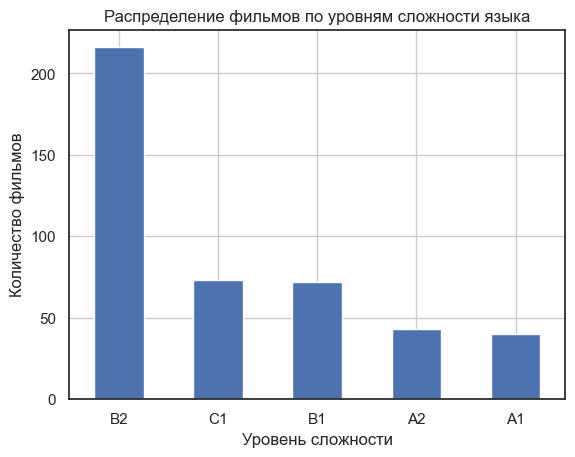

In [57]:
movies_all['level'].value_counts().plot(
    kind='bar', title='Распределение фильмов по уровням сложности языка', grid=True,
    xlabel='Уровень сложности', ylabel='Количество фильмов', rot=0
);

Конечно, не самый идеальный набор для обучения модели. И файлов мало, и явный перекос в пользу B2, но попробуем поработать с тем, что есть.

In [58]:
movies_all.to_csv('movies_all.csv', index=False)

### 1.2 Разбор файлов субтитров ###

In [59]:
# Use regexp to cleanup files from tags, html etc.
HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]'
UPPER = r'[[A-Za-z ]+[\:\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'
SYMB = r"[^\w\d'\s]"

# Функция для загрузки и лемматизации субтитров
def saving_subs(film_loc):
    # Загрузка субтитров по кодированию
    film_subs = []
    encodings = ['', 'UTF-8-SIG', 'ISO-8859-1', 'utf-8', 'Windows-1252', 'ascii']
    encoding_number = 0

    # Проверка возможности правильности кодирования, иначе - использование другого
    while not film_subs:
        try:
            film_subs = pysrt.open(
                film_loc,
                encoding=encodings[encoding_number]
            )
        except UnicodeDecodeError:
            encoding_number += 1

    #Delete garbage from text
    text = re.sub(HTML, ' ', film_subs[1:].text)
    text = re.sub(TAG, ' ', text)
    text = re.sub(COMMENTS, ' ', text)
    text = re.sub(UPPER, ' ', text)
    text = re.sub(LETTERS, ' ', text)
    text = re.sub(DOTS, r'.', text)
    text = re.sub(SPACES, r'\1', text)
    text = re.sub(SYMB, '', text)
    text = re.sub('www', '', text)
    text = text.lstrip()
    text = text.encode('ascii', 'ignore').decode()
    text = text.lower()

    # Lemmatization
    film_words = []
    text_list = text.split()
    lemmatizer = WordNetLemmatizer()

    for i in range(len(text_list)):
        word = lemmatizer.lemmatize(text_list[i])
        # Check
        if word not in film_words:
            film_words.append(word)

    # Union words into one string
    film_words = " ".join(film_words)
    return film_words

In [60]:
for index, row in movies_all.iterrows():
    print(index)
    try:
        subs = saving_subs(f"{PATH_LOCAL}English_scores/Subtitles_combined/{row['movie']}.srt")
        movies_all.loc[movies_all['movie'] == row['movie'], 'subs'] = subs
    except FileNotFoundError:
        pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [61]:
# Delete films if we've not found subtitles file
movies_all = movies_all[(movies_all['subs'] != '') & (movies_all['subs'].notna())]

In [62]:
movies_all.head()

,movie,level,level_num,subs
0,10_Cloverfield_lane(2016),B1,2,michelle please don't hang up just talk to me ...
1,10_things_I_hate_about_you(1999),B1,2,i'll be right with you so cameron here go nine...
2,A_knights_tale(2001),B2,3,should we help him he's due in the list two mi...
3,A_star_is_born(2018),B2,3,get to it black eye open wide it's time testif...
4,Aladdin(1992),A2,1,where the caravan camel roam it's flat and imm...


In [63]:
movies_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 0 to 443
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movie      397 non-null    object
 1   level      397 non-null    object
 2   level_num  397 non-null    int64 
 3   subs       397 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.5+ KB


Обогатим датасет, добавив некоторые значения, которые мы можем посчитать из лемматизированных субтитров:
- Количество уникальных слов
- Средняя длина слова
- Длина максимального слова
- Длина минимального слова
- Количество слов, входящих в Окфордский список (разделенное на А1, А2 ... С2)

In [64]:
#Count unique words
def count_unique_words(subs):
    words = subs.split()
    word_counts = Counter(words)
    unique_word_count = len(word_counts)
    return unique_word_count

movies_all['unique_words'] = movies_all['subs'].apply(count_unique_words)

In [65]:
#minimum length word
def find_shortest_word(subs):
    words = subs.split()  # разделите строку на слова
    shortest_word = min(words, key=len)  # найдите самое короткое слово
    return len(shortest_word)  # верните длину самого короткого слова

movies_all['min_length_word'] = movies_all['subs'].apply(find_shortest_word)

In [66]:
# max length word
def find_longest_word(subs):
    words = subs.split()
    longest_word = max(words, key=len)
    return len(longest_word)

movies_all['max_length_word'] = movies_all['subs'].apply(find_longest_word)

In [67]:
#average words length
def find_avg_word_length(subs):
    words = subs.split()
    total_word_length = sum(len(word) for word in words)
    return total_word_length / len(words)

movies_all['avg_length_word'] = movies_all['subs'].apply(find_avg_word_length)

In [68]:
#words and symbols count
def count_words(subs):
    return len(subs.split())

movies_all['word_count'] = movies_all['subs'].apply(count_words)
movies_all['symbols_count'] = movies_all['subs'].apply(len)

In [69]:
#Check subs with Oxford dict
words_and_levels = pd.read_csv('words_and_levels.csv')
level_dict = dict(zip(words_and_levels['Word'], words_and_levels['Level']))

# Count words of level
def count_words_by_level(subs):
    words = subs.split()  # разбить строку на слова
    levels = [level_dict.get(word, 'undefined_level') for word in words]  # получить уровни для каждого слова
    counts = pd.Series(levels).value_counts()  # подсчитать количество слов для каждого уровня
    return counts

level_counts = movies_all['subs'].apply(count_words_by_level)
movies_all = pd.concat([movies_all, level_counts], axis=1)

In [70]:
movies_all.head()

,movie,level,level_num,subs,unique_words,min_length_word,max_length_word,avg_length_word,word_count,symbols_count,undefined_level,A1,A2,B1,B2,C1
0,10_Cloverfield_lane(2016),B1,2,michelle please don't hang up just talk to me ...,1026,1,16,5.543860,1026,6713,375.0,281.0,133.0,110.0,93.0,34.0
1,10_things_I_hate_about_you(1999),B1,2,i'll be right with you so cameron here go nine...,1567,1,14,5.822591,1567,10690,662.0,345.0,174.0,160.0,163.0,63.0
2,A_knights_tale(2001),B2,3,should we help him he's due in the list two mi...,1470,1,16,5.653741,1470,9780,618.0,322.0,179.0,145.0,137.0,69.0
3,A_star_is_born(2018),B2,3,get to it black eye open wide it's time testif...,1350,1,14,5.465185,1350,8727,501.0,353.0,194.0,128.0,131.0,43.0
4,Aladdin(1992),A2,1,where the caravan camel roam it's flat and imm...,1484,1,14,5.549865,1484,9719,625.0,315.0,201.0,144.0,143.0,56.0


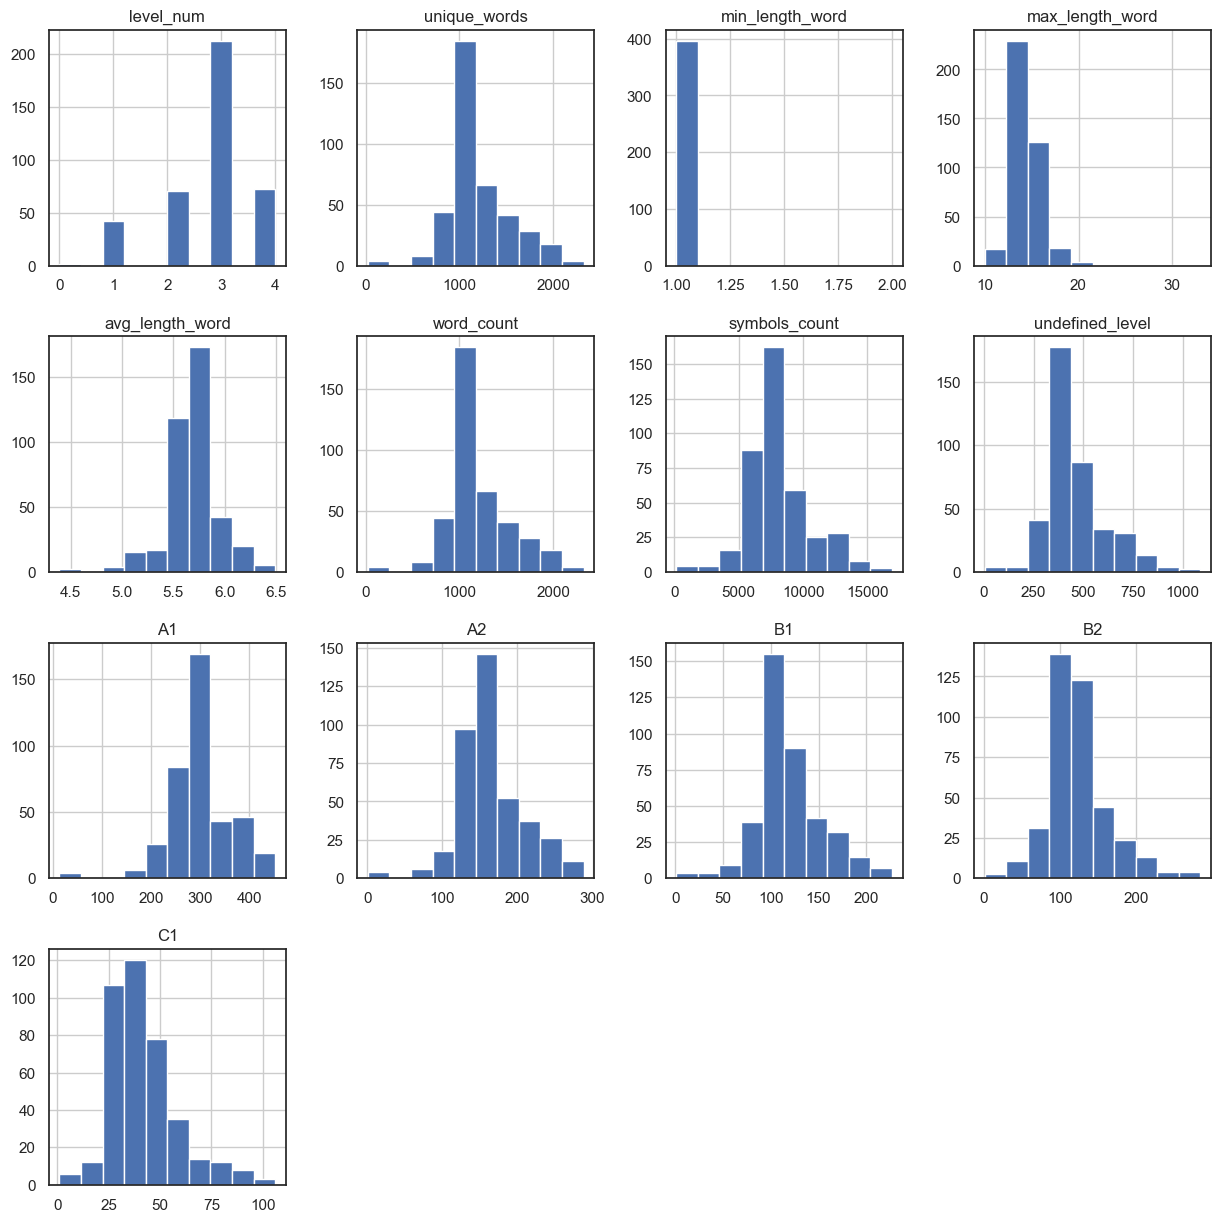

In [71]:
movies_all.hist(figsize=(15, 15))
plt.show()

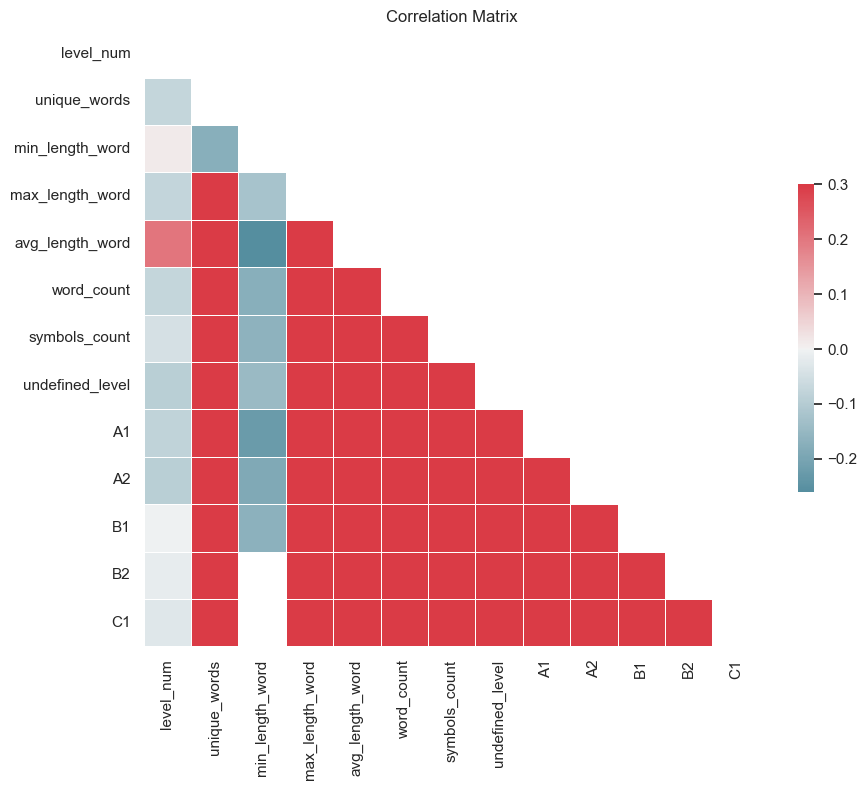

In [72]:
numeric = ['level_num','unique_words', 'min_length_word', 'max_length_word', 'avg_length_word', 'word_count', 'symbols_count', 'undefined_level', 'A1', 'A2', 'B1', 'B2', 'C1']
corr_matrix = movies_all[numeric].corr()

# построить график корреляций
sns.set(style='white')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

Кажется, что колонка min_length_word не имеет значения, т.к. там у всех субтитров значение 1, очевидно, в любых субтитрах будет артикль a. Поэтому, удалим, пожалуй, эту колонку. Колонку level тоже удалим, она у нас закодирована в level_num.

In [73]:
movies_all.drop('min_length_word', axis=1, inplace=True)
movies_all.drop('level', axis=1, inplace=True)

In [74]:
numeric = ['level_num','unique_words', 'max_length_word', 'avg_length_word', 'word_count', 'symbols_count', 'undefined_level', 'A1', 'A2', 'B1', 'B2', 'C1']
corr_matrix = movies_all[numeric].corr()
corr_matrix

,level_num,unique_words,max_length_word,avg_length_word,word_count,symbols_count,undefined_level,A1,A2,B1,B2,C1
level_num,1.000000,-0.072791,-0.075561,0.202495,-0.072791,-0.044698,-0.092273,-0.080885,-0.090967,-0.003118,-0.013608,-0.030352
unique_words,-0.072791,1.000000,0.409907,0.603489,1.000000,0.994889,0.981948,0.932128,0.968623,0.957455,0.932839,0.856085
max_length_word,-0.075561,0.409907,1.000000,0.382122,0.409907,0.421047,0.372029,0.386024,0.439563,0.395102,0.418777,0.374727
avg_length_word,0.202495,0.603489,0.382122,1.000000,0.603489,0.666079,0.520091,0.494314,0.628870,0.688926,0.721758,0.694227
word_count,-0.072791,1.000000,0.409907,0.603489,1.000000,0.994889,0.981948,0.932128,0.968623,0.957455,0.932839,0.856085
symbols_count,-0.044698,0.994889,0.421047,0.666079,0.994889,1.000000,0.970238,0.910144,0.967274,0.966403,0.952727,0.881055
undefined_level,-0.092273,0.981948,0.372029,0.520091,0.981948,0.970238,1.000000,0.888035,0.921785,0.910093,0.881811,0.823337
A1,-0.080885,0.932128,0.386024,0.494314,0.932128,0.910144,0.888035,1.000000,0.921258,0.876310,0.812554,0.682726
A2,-0.090967,0.968623,0.439563,0.628870,0.968623,0.967274,0.921785,0.921258,1.000000,0.940787,0.915570,0.816393
B1,-0.003118,0.957455,0.395102,0.688926,0.957455,0.966403,0.910093,0.876310,0.940787,1.000000,0.930017,0.862618


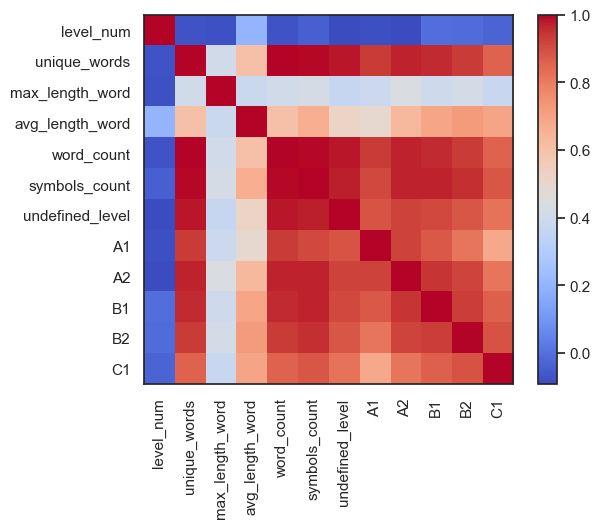

In [75]:
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

Интересная картинка, конечно. Уровень субтитров, указанный в исходных данных, почти никак не коррелирует ни с оксфордским словарём, ни с другими параметрами. Поэтому, использовать слишком коррелирующие значения в предсказаниях бессмысленно. Будем использовать только колонку level_num и текст субтитров.

## 2. Выбор метрики и создание модели ##

У нас задача классификации. Для этого нам лучше всего использовать метрику f1 для определения качества работы модели. Она сочетает в себе и точность (precision), и полноту (recall). Но мы имеем дело с мультиклассификацией (один и тот же текст может относиться к нескольким уровням), то необходимо воспользоваться "Макро F1-мерой" (показывает среднее значение F1-меры по классам) и "Микро F1-мерой" (глобальная средняя F1-меры, вычисляющая сумму TP, FN и FP).
Таким образом, для определения качества моделей будем использовать f1_micro и f1_macro.

In [76]:
columns = ['subs','unique_words', 'max_length_word', 'avg_length_word', 'word_count', 'symbols_count', 'undefined_level', 'A1', 'A2', 'B1', 'B2', 'C1']
X = movies_all['subs']
y = movies_all['level_num']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [78]:
# Predict and print metrics
vectorizer = TfidfVectorizer(stop_words='english')

def count_and_print_f1_score(model):
    pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Check
    print(f"{model}:")
    print("\tf1_micro: {:.4f}".format(f1_score(y_test, y_pred, average='micro')))
    print("\tf1_macro: {:.4f}".format(f1_score(y_test, y_pred, average='macro')))

In [79]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=20, criterion='entropy')
count_and_print_f1_score(tree_model)

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42):
	f1_micro: 0.6750
	f1_macro: 0.4830


In [80]:
logreg_model = LogisticRegression(random_state=42, max_iter=300, C=35)
count_and_print_f1_score(logreg_model)

LogisticRegression(C=35, max_iter=300, random_state=42):
	f1_micro: 0.7125
	f1_macro: 0.4646


In [81]:
ridge_model = RidgeClassifier(random_state=42, alpha=0.1)
count_and_print_f1_score(ridge_model)

RidgeClassifier(alpha=0.1, random_state=42):
	f1_micro: 0.7625
	f1_macro: 0.5275


In [82]:
svc_model = SGDClassifier(random_state=42, loss='huber', alpha=0.0001, penalty='elasticnet', l1_ratio=0.01)
count_and_print_f1_score(svc_model)

SGDClassifier(l1_ratio=0.01, loss='huber', penalty='elasticnet',
              random_state=42):
	f1_micro: 0.7625
	f1_macro: 0.5275


In [83]:
svc_model = LinearSVC(random_state=42, C=3)
count_and_print_f1_score(svc_model)

LinearSVC(C=3, random_state=42):
	f1_micro: 0.7625
	f1_macro: 0.5314


Из 6 рассмотренных моделей наилучший результат по метрикам 'f1_micro' и 'f1_macro' продемонстрировала модель:
LinearSVC(C=3, random_state=42):
	- f1_micro: 0.7625
	- f1_macro: 0.5314

Поиграем с её гиперпараметрами, чтобы получить наилучшие значения f1_micro и f1_macro

In [84]:
# Define pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('model', LinearSVC(random_state=42))
])

# Define hyperparameters
parameters = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [3000, 5000, 10000],
    'model__tol': [1e-3, 1e-4, 1e-5],
    'model__dual': [False, True],
    'model__class_weight': ['balanced', None]
}

# Create grid search object
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=['f1_micro', 'f1_macro'], refit='f1_micro')
# Fit grid search object to data
grid_search.fit(X_train, y_train)

# Print best score and parameters
print("Best f1_micro score: {:.4f}".format(grid_search.best_score_))
print("Best parameters: ", grid_search.best_params_)

# Calculate f1 scores with best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\tf1_micro: {:.4f}".format(f1_score(y_test, y_pred, average='micro')))
print("\tf1_macro: {:.4f}".format(f1_score(y_test, y_pred, average='macro')))

/Users/kuuuzya/PythonProjects/Practicum/Master_2_Subtitles/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kuuuzya/PythonProjects/Practicum/Master_2_Subtitles/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kuuuzya/PythonProjects/Practicum/Master_2_Subtitles/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kuuuzya/PythonProjects/Practicum/Master_2_Subtitles/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kuuuzya/PythonProjects/Practicum/Master_2_Subtitles/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:124

Best f1_micro score: 0.8234
Best parameters:  {'model__C': 100, 'model__class_weight': 'balanced', 'model__dual': False, 'model__max_iter': 5000, 'model__penalty': 'l1', 'model__tol': 0.0001}
	f1_micro: 0.7875
	f1_macro: 0.5791


In [85]:
count_and_print_f1_score(best_model.named_steps['model'])

LinearSVC(C=100, class_weight='balanced', dual=False, max_iter=5000,
          penalty='l1', random_state=42):
	f1_micro: 0.7875
	f1_macro: 0.5791


Немного улучшили метрики модели, можно переходить к сохранению модели в файл и созданию приложения.

### Создание приложения

In [86]:
from pickle import dump

best_model.fit(X_train, y_train)

with open('./main.pcl', 'wb') as model_file:
    dump(best_model, model_file)

Далее эту модель загрузим в приложение Streamlit. Его код в файле main.py